In [17]:
### Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Model's Mean Squared Error: 0.004170097876340151
Root Mean Squared Error: 125.24647560789175
----------Learning Curve----------


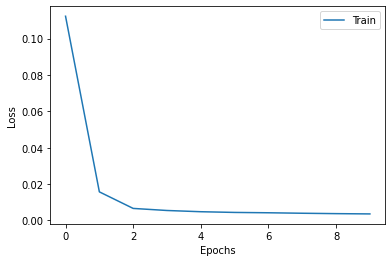

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               42800     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 3, 100)           0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 3, 100)            80400     
                                                                 
 time_distributed_5 (TimeDis  (None, 3, 6)             606       
 tributed)                                                       
                                                                 
Total params: 123,806
Trainable params: 123,806
Non-trainable params: 0
_________________________________________________________________
Mean Squared Error: 1071.9006768404354
Root Mean

In [18]:
### Plot function
def plot_multiple_series(actual, pred, attr):
    if len(actual) != len(pred):
        return "Error: The lengths of the two data must be the same!"
    x = range(len(pred))
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(x, actual.iloc[:,i], label="actual")
        plt.plot(x, pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()


### Visualise the data
file_name = "phy_cps.csv"
attr = list(pd.read_csv(file_name).columns.values)[1:]

mse_list = []
rmse_list = []
mae_list = []
rsqr_list = []


# Load and preprocess data
data = pd.read_csv(file_name, header=0, index_col=0)
raw_data = data.values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(raw_data)

# Split data into train and test sets
# train_size = int(len(data) * 0.7)
# train_size = 12000
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data),:]

# Define the number of time steps and features
n_steps_in = 5
n_steps_out = 3
n_features = data.shape[1]

# Reshape data for LSTM
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix-1:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

# Define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

# Compile and fit the model
model.compile(optimizer='adam', loss='mse')
train_history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print("Model's Mean Squared Error:", mse)

# Make predictions on test data
y_pred = model.predict(X_test)

# Reshape predictions for inverse scaling
# y_pred_reshaped = y_pred.reshape((y_pred.shape[0]*y_pred.shape[1], n_steps_out, n_features))
# y_test_reshaped = y_test.reshape((y_test.shape[0]*y_test.shape[1], n_steps_out, n_features))

# Extract only the result of prediction for n_steps_out=3
result_pred = y_pred[:, -n_steps_out:, :]

# Reshaping


# Inverse scale predictions and test data
result_pred_inv = scaler.inverse_transform(result_pred.reshape(-1, n_features))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, n_features))

# print(result_pred_inv.shape)
# print(result_pred_inv)
# Calculate RMSE
# rmse = np.sqrt(np.mean((y_pred_inv - y_test_inv)**2))
rmse = np.sqrt(np.mean((result_pred_inv - y_test_inv)**2))
print('Root Mean Squared Error:', rmse)

# Plot curve
print("----------Learning Curve----------")
plt.plot(train_history.history['loss'], label='Train')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

for i in range(1, len(attr)+1):
    mse = mean_squared_error(y_test_inv[i], result_pred_inv[i])
    mse_list.append(mse)
    print(f'Mean Squared Error: {mse}')

    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f'Root Mean Squared Error: {rmse}')

    mae = mean_absolute_error(y_test_inv[i], result_pred_inv[i])
    mae_list.append(mae)
    print(f'Mean Absolute Error: {mae}')

    r_sqr = r2_score(y_test_inv[i], result_pred_inv[i])
    rsqr_list.append(r_sqr)
    print(f'R2 Score: {r_sqr}\n')
